### Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import scatter_matrix
from sklearn import set_config
set_config(display='diagram')

from itertools import combinations
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge




from optuna import create_study, Trial
from optuna.samplers import TPESampler


### Loading the Data

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s6e1/sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/exam-score-prediction-dataset/Exam_Score_Prediction.csv')

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test.shape)
print("Original shape:", original_df.shape)
print("\nTrain columns:", train_df.columns.tolist())
print("Original columns:", original_df.columns.tolist())

Train shape: (630000, 13)
Test shape: (270000, 12)
Original shape: (20000, 13)

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']
Original columns: ['student_id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']


In [4]:
train = pd.concat([train_df, original_df], axis=0, ignore_index=True)
print("\nCombined train + original shape:", train.shape)


Combined train + original shape: (650000, 14)


### Basic Statistics 

In [5]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,student_id
0,0.0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3,NaN
1,1.0,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7,NaN
2,2.0,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0,NaN
3,3.0,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9,NaN
4,4.0,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0,NaN


In [6]:
train = train.drop('student_id', axis=1)

In [7]:
test.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  float64
 1   age               650000 non-null  int64  
 2   gender            650000 non-null  object 
 3   course            650000 non-null  object 
 4   study_hours       650000 non-null  float64
 5   class_attendance  650000 non-null  float64
 6   internet_access   650000 non-null  object 
 7   sleep_hours       650000 non-null  float64
 8   sleep_quality     650000 non-null  object 
 9   study_method      650000 non-null  object 
 10  facility_rating   650000 non-null  object 
 11  exam_difficulty   650000 non-null  object 
 12  exam_score        650000 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 64.5+ MB


In [9]:
train.dtypes

id                  float64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

In [10]:
print("Target column statistics (exam_score):")

train['exam_score'].describe()

Target column statistics (exam_score):


count    650000.000000
mean         62.506874
std          18.916611
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64

In [11]:
train.isnull().sum()

id                  20000
age                     0
gender                  0
course                  0
study_hours             0
class_attendance        0
internet_access         0
sleep_hours             0
sleep_quality           0
study_method            0
facility_rating         0
exam_difficulty         0
exam_score              0
dtype: int64

In [12]:
print("Duplicated Rows:",train.duplicated().sum())

Duplicated Rows: 0


In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,630000.0,314999.500000,181865.479132,0.000,157499.75,314999.50,472499.25,629999.00
age,650000.0,20.543589,2.261020,17.000,19.00,21.00,23.00,24.00
study_hours,650000.0,4.002499,2.358309,0.080,1.98,4.01,6.05,7.91
class_attendance,650000.0,71.926649,17.428875,40.600,57.00,72.50,87.10,99.40
sleep_hours,650000.0,7.070783,1.744455,4.100,5.60,7.10,8.60,9.90
exam_score,650000.0,62.506874,18.916611,19.599,48.80,62.60,76.30,100.00


### Exploratory Data Analysis

#### Numerical Features Distribution

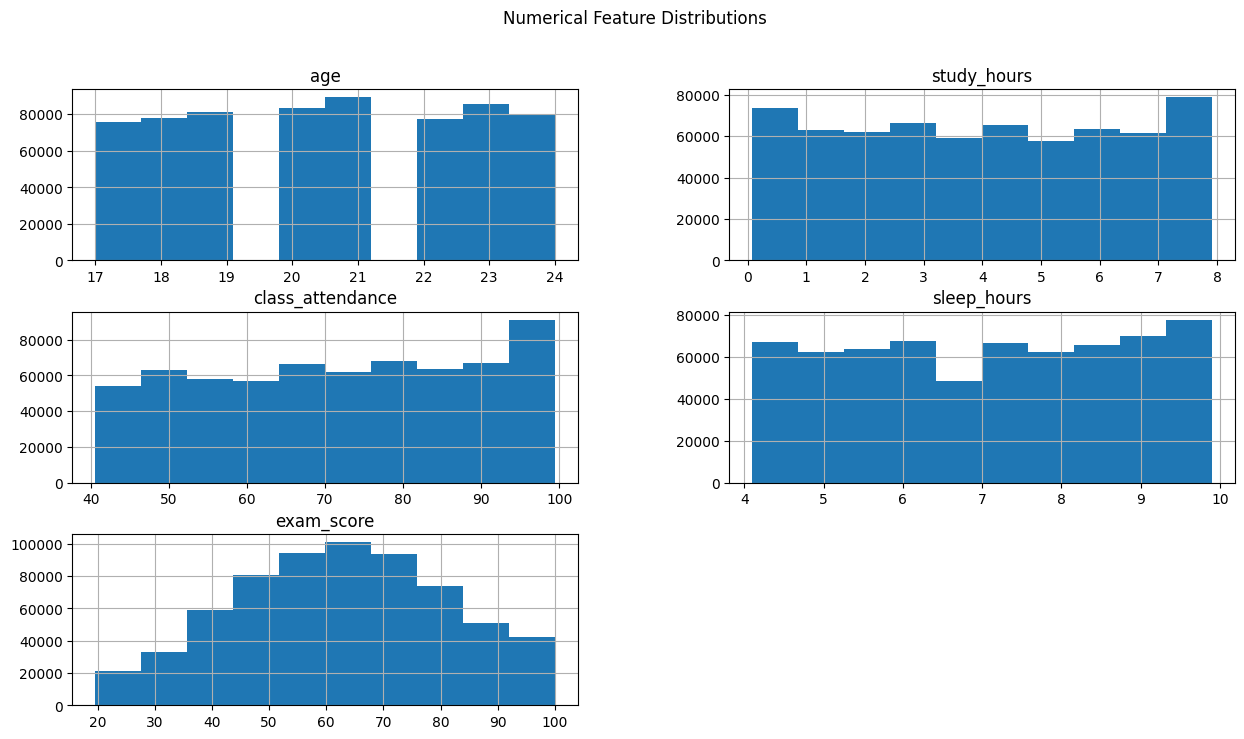

In [14]:
num_cols = train.select_dtypes(include=[np.number]).columns.drop('id')
train[num_cols].hist(figsize=(15, 8), bins=10)
plt.suptitle("Numerical Feature Distributions")
plt.show()

### Correlation Matrix

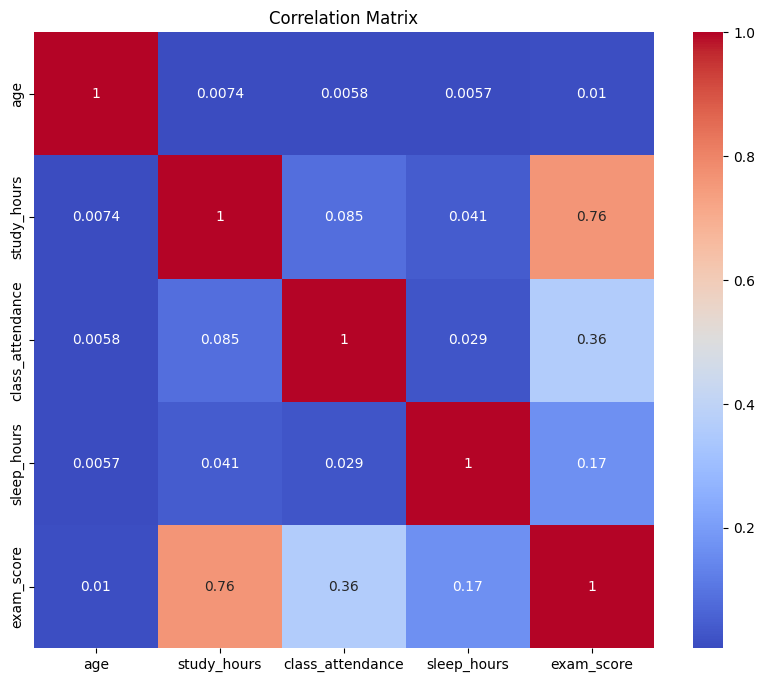

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Scatter Matrix

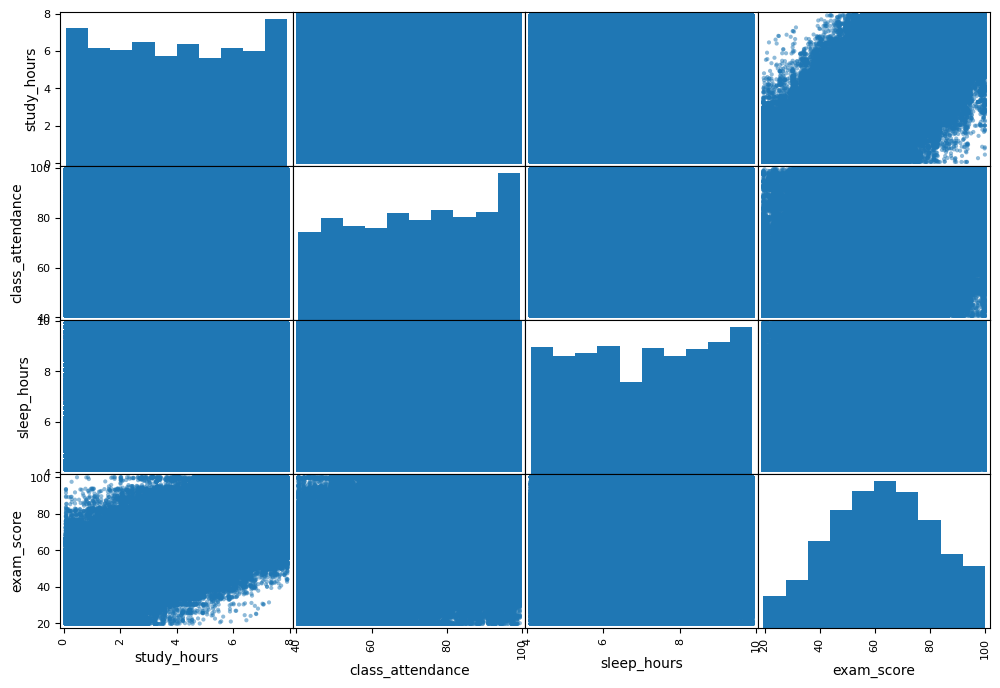

In [16]:
attributes = [ "study_hours", "class_attendance",
     "sleep_hours","exam_score"]
scatter_matrix(train[attributes], figsize=(12, 8))
plt.show()

#### Boxplots for Outlier Detection

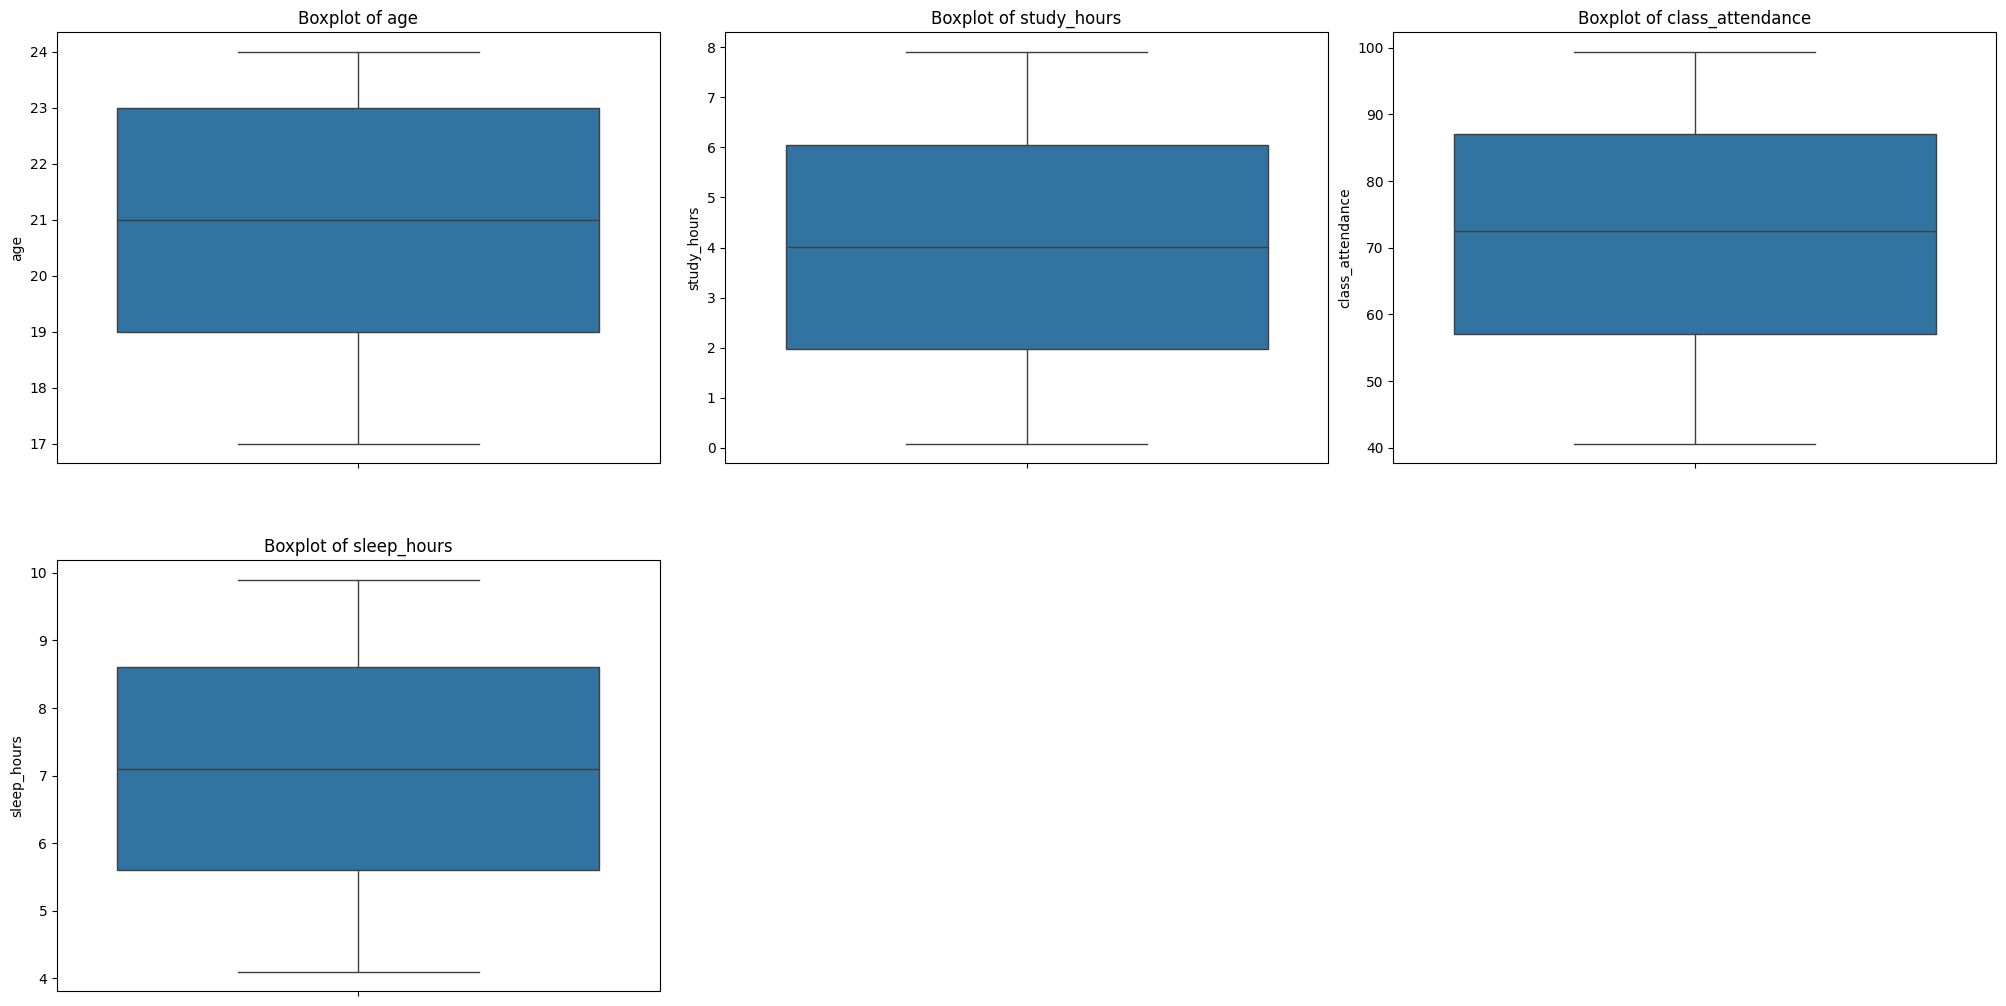

In [17]:
num_cols = num_cols.drop('exam_score') 
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()

index = 0
for col in num_cols:
    sns.boxplot(y=col, data=train, ax=ax[index])
    ax[index].set_title(f"Boxplot of {col}")
    index += 1


for j in range(index, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

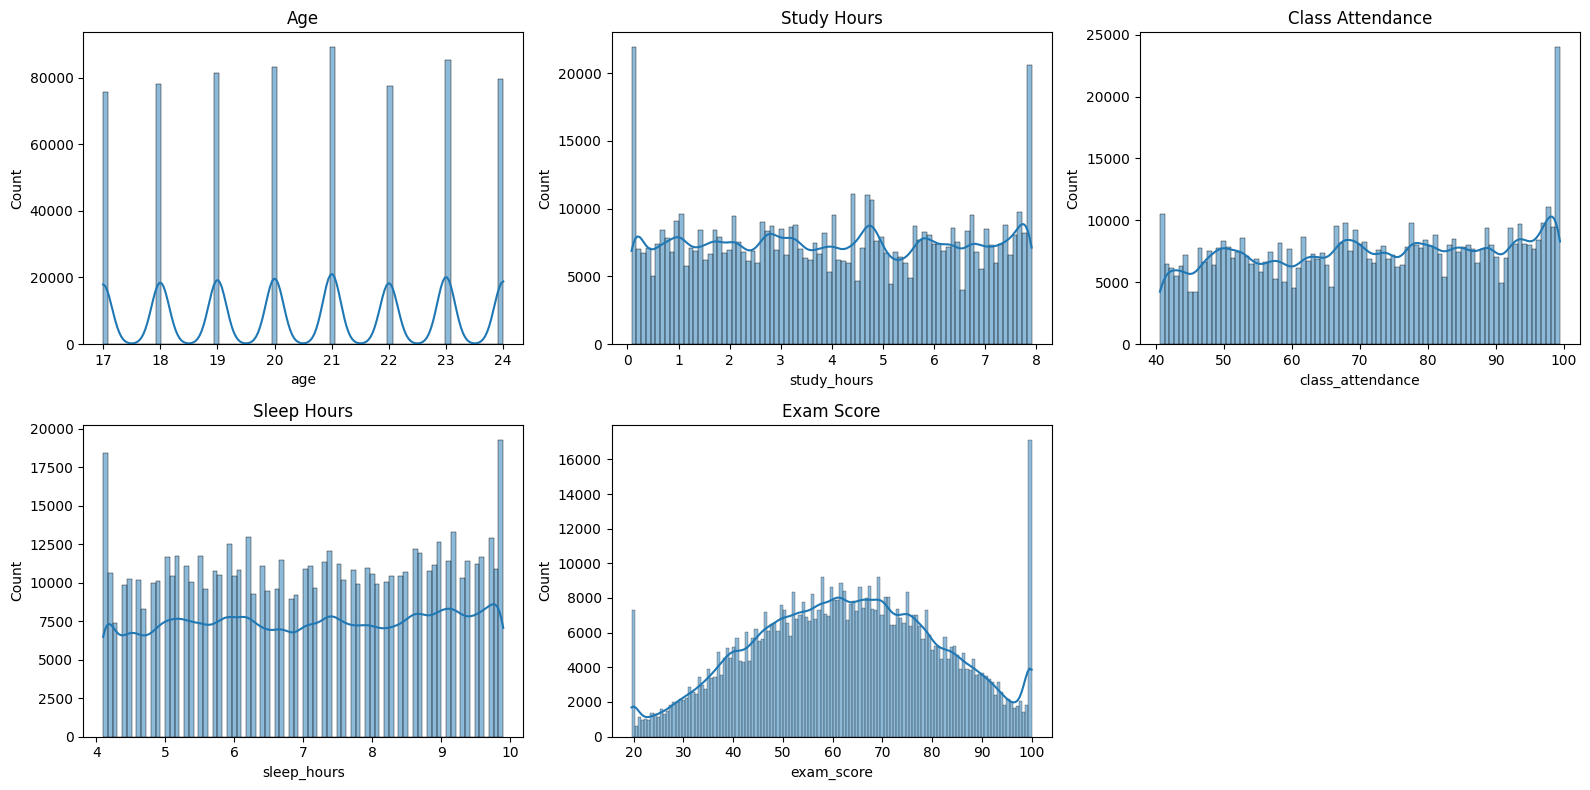

In [18]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
sns.histplot(train['age'], kde=True)
plt.title('Age')

plt.subplot(2, 3, 2)
sns.histplot(train['study_hours'], kde=True)
plt.title('Study Hours')

plt.subplot(2, 3, 3)
sns.histplot(train['class_attendance'], kde=True)
plt.title('Class Attendance')

plt.subplot(2, 3, 4)
sns.histplot(train['sleep_hours'], kde=True)
plt.title('Sleep Hours')

plt.subplot(2, 3, 5)
sns.histplot(train['exam_score'], kde=True)
plt.title('Exam Score')

plt.tight_layout()
plt.show()


### Removing the outliers

#### IQR Method

In [19]:

def remove_outliers_with_bounds(data, column, Q1, Q3):
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]



for col in ['age', 'study_hours', 'sleep_hours', 'class_attendance']:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    
 
    train = remove_outliers_with_bounds(train, col, Q1, Q3)
    test = remove_outliers_with_bounds(test, col, Q1, Q3)

### Feature Engineering

In [20]:
    
def engineer_features(train, test, target='exam_score', 
                                 nums=None, cats=None, verbose=True):
       
   
    if nums is None:
        nums = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
    if cats is None:
        cats = ['gender', 'course', 'internet_access', 'sleep_quality', 
                'study_method', 'facility_rating', 'exam_difficulty']
    
    feature_summary = {
        'binned': 0,
        'domain_knowledge': 0,
        'interactions': 0,
        'polynomial': 0,
        'cat_pairs': 0,
        'target_encoded': 0,
        'aggregation': 0,
        'ratio_difference': 0
    }
    

    if verbose:
        print("Creating binned features...")
    
    bin_features_train = pd.DataFrame(index=train.index)
    bin_features_test = pd.DataFrame(index=test.index)
    
    for c in nums:
        for q in [3, 5]:
            try:
                train_bins, bins = pd.qcut(train[c], q=q, labels=False, 
                                          retbins=True, duplicates="drop")
                bin_features_train[f"{c}_bin{q}"] = train_bins
                bin_features_test[f"{c}_bin{q}"] = pd.cut(test[c], bins=bins, 
                                                          labels=False, include_lowest=True)
                feature_summary['binned'] += 1
            except Exception:
                bin_features_train[f"{c}_bin{q}"] = 0
                bin_features_test[f"{c}_bin{q}"] = 0
                feature_summary['binned'] += 1
    
    train = pd.concat([train, bin_features_train], axis=1)
    test = pd.concat([test, bin_features_test], axis=1)
    

    if verbose:
        print("Creating domain knowledge features...")
    
    train['academic_index'] = (train['study_hours'] * 0.40 + 
                               train['class_attendance'] / 100 * 0.35 + 
                               train['sleep_hours'] / 10 * 0.25)
    test['academic_index'] = (test['study_hours'] * 0.40 + 
                              test['class_attendance'] / 100 * 0.35 + 
                              test['sleep_hours'] / 10 * 0.25)
    feature_summary['domain_knowledge'] += 1
    
    train['study_efficiency'] = train['class_attendance'] / (train['study_hours'] + 1)
    test['study_efficiency'] = test['class_attendance'] / (test['study_hours'] + 1)
    feature_summary['domain_knowledge'] += 1
    
    train['sleep_efficiency'] = train['sleep_hours'] / 8
    test['sleep_efficiency'] = test['sleep_hours'] / 8
    feature_summary['domain_knowledge'] += 1
    

    if verbose:
        print("Creating interaction features...")
    
    for cols in tqdm(list(combinations(nums, 2)), disable=not verbose):
        name = f"{cols[0]}-{cols[1]}"
        train[name] = train[cols[0]] * train[cols[1]]
        test[name] = test[cols[0]] * test[cols[1]]
        feature_summary['interactions'] += 1
    
    for c in ['study_hours', 'class_attendance', 'sleep_hours', 'age']:
        name = f"{c}_sq"
        train[name] = train[c] ** 2
        test[name] = test[c] ** 2
        feature_summary['polynomial'] += 1
    
    train['study_hours_cubed'] = train['study_hours'] ** 3
    test['study_hours_cubed'] = test['study_hours'] ** 3
    feature_summary['polynomial'] += 1
    
    train['log_study_hours'] = np.log1p(train['study_hours'])
    test['log_study_hours'] = np.log1p(test['study_hours'])
    feature_summary['polynomial'] += 1
    
    train['log_class_attendance'] = np.log1p(train['class_attendance'])
    test['log_class_attendance'] = np.log1p(test['class_attendance'])
    feature_summary['polynomial'] += 1
    
    train['log_sleep_hours'] = np.log1p(train['sleep_hours'])
    test['log_sleep_hours'] = np.log1p(test['sleep_hours'])
    feature_summary['polynomial'] += 1
    
    train['sqrt_study_hours'] = np.sqrt(train['study_hours'])
    test['sqrt_study_hours'] = np.sqrt(test['study_hours'])
    feature_summary['polynomial'] += 1
    
    train['sqrt_class_attendance'] = np.sqrt(train['class_attendance'])
    test['sqrt_class_attendance'] = np.sqrt(test['class_attendance'])
    feature_summary['polynomial'] += 1
    

    if verbose:
        print("Encoding categorical features...")
    
    for c in cats:
        combined = pd.concat([train[c], test[c]], ignore_index=True)
        combined_encoded, _ = combined.factorize()
        train[c] = combined_encoded[:len(train)]
        test[c] = combined_encoded[len(train):]
    

    if verbose:
        print("Creating categorical interaction pairs...")
    
    for cols in tqdm(list(combinations(cats, 2)), disable=not verbose):
        name = '-'.join(cols)
        train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
        test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)
        
        combined = pd.concat([train[name], test[name]], ignore_index=True)
        combined_encoded, _ = combined.factorize()
        train[name] = combined_encoded[:len(train)]
        test[name] = combined_encoded[len(train):]
        feature_summary['cat_pairs'] += 1
    

    if verbose:
        print("Applying target encoding...")
    
    for c in cats:

        tmp = train.groupby(c)[target].mean().astype('float32')
        tmp.name = f"TE_{c}"
        train = train.merge(tmp, on=c, how='left')
        train[tmp.name] = train[tmp.name].fillna(train[tmp.name].mean())
        test = test.merge(tmp, on=c, how='left')
        test[tmp.name] = test[tmp.name].fillna(train[tmp.name].mean())
        feature_summary['target_encoded'] += 1
        
 
        ce_name = f"CE_{c}"
        counts = train[c].value_counts()
        train[ce_name] = train[c].map(counts).fillna(0)
        test[ce_name] = test[c].map(counts).fillna(0)
        feature_summary['target_encoded'] += 1
    

    if verbose:
        print("Creating numerical-categorical target encodings...")
    
    for num_col in nums:
        for cat_col in cats:
            te_name = f"TE_{num_col}_by_{cat_col}"
            tmp = train.groupby(cat_col)[num_col].mean().astype('float32')
            tmp.name = te_name
            train = train.merge(tmp, on=cat_col, how='left')
            train[te_name] = train[te_name].fillna(train[te_name].mean())
            test = test.merge(tmp, on=cat_col, how='left')
            test[te_name] = test[te_name].fillna(train[te_name].mean())
            feature_summary['aggregation'] += 1
    

    if verbose:
        print("Creating aggregation features...")
    
    for c in cats:
        for num_col in nums:
            agg_name = f"AGG_{num_col}_mean_by_{c}"
            tmp = train.groupby(c)[num_col].mean().astype('float32')
            tmp.name = agg_name
            train = train.merge(tmp, on=c, how='left')
            train[agg_name] = train[agg_name].fillna(train[agg_name].mean())
            test = test.merge(tmp, on=c, how='left')
            test[agg_name] = test[agg_name].fillna(train[agg_name].mean())
            feature_summary['aggregation'] += 1
    
 
    if verbose:
        print("Creating ratio and difference features...")
    
    for cols in tqdm(list(combinations(nums, 2)), disable=not verbose):
    
        ratio_name = f"{cols[0]}_div_{cols[1]}"
        train[ratio_name] = train[cols[0]] / (train[cols[1]] + 1)
        test[ratio_name] = test[cols[0]] / (test[cols[1]] + 1)
        feature_summary['ratio_difference'] += 1
        
  
        diff_name = f"{cols[0]}_minus_{cols[1]}"
        train[diff_name] = train[cols[0]] - train[cols[1]]
        test[diff_name] = test[cols[0]] - test[cols[1]]
        feature_summary['ratio_difference'] += 1
    

    if verbose:
        print("Optimizing data types...")
    
    for c in train.columns.tolist():
   
        if c == target or c == 'id':
            continue
            
        if train[c].dtype == 'float64':
            train[c] = train[c].astype('float32')
            if c in test.columns:
                test[c] = test[c].astype('float32')
        elif train[c].dtype == 'int64':
            train[c] = train[c].astype('int32')
            if c in test.columns:
                test[c] = test[c].astype('int32')
    

    features = train.columns.tolist()
    if target in features:
        features.remove(target)
    if 'id' in features:
        features.remove('id')
    
    if verbose:
        print(f"\n✓ Feature Engineering Complete!")
        print(f"Original features: {len(nums) + len(cats)}")
        print(f"Total features after engineering: {len(features)}")
        print(f"  - Binned features: {feature_summary['binned']}")
        print(f"  - Domain knowledge features: {feature_summary['domain_knowledge']}")
        print(f"  - Interaction pairs: {feature_summary['interactions']}")
        print(f"  - Polynomial features: {feature_summary['polynomial']}")
        print(f"  - Categorical pairs: {feature_summary['cat_pairs']}")
        print(f"  - Target encoded features: {feature_summary['target_encoded']}")
        print(f"  - Aggregation features: {feature_summary['aggregation']}")
        print(f"  - Ratio/Difference features: {feature_summary['ratio_difference']}")
        print(f"\nTrain shape: {train.shape}")
        print(f"Test shape: {test.shape}")
    
    return train, test, features, feature_summary


train, test, features, summary = engineer_features(
    train=train,
    test=test,
    target='exam_score',
    nums=['age', 'study_hours', 'class_attendance', 'sleep_hours'],
    cats=['gender', 'course', 'internet_access', 'sleep_quality', 
          'study_method', 'facility_rating', 'exam_difficulty'],
    verbose=True
)


Creating binned features...
Creating domain knowledge features...
Creating interaction features...


100%|██████████| 6/6 [00:00<00:00, 181.49it/s]

Encoding categorical features...


Creating categorical interaction pairs...


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Applying target encoding...
Creating numerical-categorical target encodings...
Creating aggregation features...
Creating ratio and difference features...


100%|██████████| 6/6 [00:00<00:00, 118.93it/s]

Optimizing data types...



✓ Feature Engineering Complete!
Original features: 11
Total features after engineering: 141
  - Binned features: 8
  - Domain knowledge features: 3
  - Interaction pairs: 6
  - Polynomial features: 10
  - Categorical pairs: 21
  - Target encoded features: 14
  - Aggregation features: 56
  - Ratio/Difference features: 12

Train shape: (650000, 143)
Test shape: (270000, 142)


In [21]:
y_train = train['exam_score']
X_train = train.drop('exam_score', axis=1)

X_test = test.copy()

In [22]:
if 'id' in X_train.columns:
    X_train = X_train.drop('id', axis=1)
if 'id' in X_test.columns:
    X_test = X_test.drop('id', axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

X_train shape: (650000, 141)
y_train shape: (650000,)
X_test shape: (270000, 141)



In [23]:
X_train.columns

Index(['age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating',
       ...
       'age_div_class_attendance', 'age_minus_class_attendance',
       'age_div_sleep_hours', 'age_minus_sleep_hours',
       'study_hours_div_class_attendance',
       'study_hours_minus_class_attendance', 'study_hours_div_sleep_hours',
       'study_hours_minus_sleep_hours', 'class_attendance_div_sleep_hours',
       'class_attendance_minus_sleep_hours'],
      dtype='object', length=141)

In [24]:
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "n_estimators": 3000,
    "learning_rate": 0.03,
    "max_depth": 8,
    "subsample": 0.85,
    "colsample_bytree": 0.54,
    "colsample_bynode": 0.7,
    "min_child_weight": 3,
    "reg_lambda": 3.0,
    "gamma": 0.1,
    "max_delta_step": 1,
    "tree_method": "hist",
    "device": "cuda",
    "random_state": 42,
    "early_stopping_rounds": 100,
    "verbosity": 0,
    "n_jobs": -1,
}


lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "n_estimators": 3000,
    "learning_rate": 0.03,
    "num_leaves": 128,  
    "max_depth": 8,
    "subsample": 0.85,
    "colsample_bytree": 0.54,
    "min_child_samples": 20,
    "reg_lambda": 3.0,
    "random_state": 42,
    "n_jobs": -1,
    "verbose": -1,
    "force_row_wise": True,
    "device": "gpu",
    "gpu_device_id": 0,
    "early_stopping_rounds": 100,
}

cat_params = {
    "loss_function": "RMSE",
    "iterations": 3000,
    "learning_rate": 0.03,
    "depth": 8,
    "l2_leaf_reg": 3.0,
    "bootstrap_type": "Bernoulli",
    "subsample": 0.85,
    "task_type": "GPU",
    "devices": "0",
    "early_stopping_rounds": 100,
    "random_seed": 42,
    "verbose": False,
    "leaf_estimation_method": "Gradient",
    "grow_policy": "SymmetricTree",
    "nan_mode": "Min",
}

In [25]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)


oof_xgb = np.zeros(len(X_train))
oof_lgb = np.zeros(len(X_train))
oof_cat = np.zeros(len(X_train))


test_xgb = np.zeros((len(X_test), n_splits))
test_lgb = np.zeros((len(X_test), n_splits))
test_cat = np.zeros((len(X_test), n_splits))

print("="*60)
print(f"Running {n_splits}-Fold XGB + LGB + CAT CV with stacking")
print("="*60)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

  
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    val_xgb = xgb_model.predict(X_val)
    test_xgb[:, fold-1] = xgb_model.predict(X_test)
    oof_xgb[val_idx] = val_xgb

 
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)]
    )
    val_lgb = lgb_model.predict(X_val)
    test_lgb[:, fold-1] = lgb_model.predict(X_test)
    oof_lgb[val_idx] = val_lgb


    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        verbose=False
    )
    val_cat = cat_model.predict(X_val)
    test_cat[:, fold-1] = cat_model.predict(X_test)
    oof_cat[val_idx] = val_cat

    print(f"Fold {fold} | XGB RMSE: {np.sqrt(mean_squared_error(y_val, val_xgb)):.4f} "
          f"| LGB RMSE: {np.sqrt(mean_squared_error(y_val, val_lgb)):.4f} "
          f"| CAT RMSE: {np.sqrt(mean_squared_error(y_val, val_cat)):.4f}")


stacked_train = np.vstack([oof_xgb, oof_lgb, oof_cat]).T
stacked_test = np.vstack([test_xgb.mean(axis=1), test_lgb.mean(axis=1), test_cat.mean(axis=1)]).T


meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(stacked_train, y_train)


oof_ensemble = meta_model.predict(stacked_train)
rmse_ensemble = np.sqrt(mean_squared_error(y_train, oof_ensemble))
print("\n" + "="*60)
print(f"Stacked Ensemble OOF RMSE: {rmse_ensemble:.4f}")


y_test_final = meta_model.predict(stacked_test)
print(f"Test predictions shape: {y_test_final.shape}")
print(f"Prediction range: [{y_test_final.min():.2f}, {y_test_final.max():.2f}]")
print("="*60)

Running 5-Fold XGB + LGB + CAT CV with stacking


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 | XGB RMSE: 8.8065 | LGB RMSE: 8.7883 | CAT RMSE: 8.8130
Fold 2 | XGB RMSE: 8.8252 | LGB RMSE: 8.8076 | CAT RMSE: 8.8336
Fold 3 | XGB RMSE: 8.8084 | LGB RMSE: 8.7861 | CAT RMSE: 8.8166
Fold 4 | XGB RMSE: 8.8316 | LGB RMSE: 8.8098 | CAT RMSE: 8.8350
Fold 5 | XGB RMSE: 8.8270 | LGB RMSE: 8.8048 | CAT RMSE: 8.8334

Stacked Ensemble OOF RMSE: 8.7921
Test predictions shape: (270000,)
Prediction range: [16.74, 102.02]


In [26]:
submission = submission.copy()
submission['exam_score'] = y_test_final

submission.to_csv('submission.csv', index=False)
print("\n Submission saved to 'submission.csv'")


 Submission saved to 'submission.csv'


In [27]:
submission.head()

,id,exam_score
0,630000,70.948176
1,630001,71.795628
2,630002,87.536037
3,630003,55.559986
4,630004,47.330498
